In [1]:
from src.ml.ml_mlp import MLP_Model
from src.ml.ml_mlp import Linear_Model
from src.ml.ml_mlp import MLP_Win_Model
from src.ml.ml_mlp import LSTM_Model
import src
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import multiprocessing
# multiprocessing.set_start_method("spawn")
# from launch_tb import launch_tb

In [2]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
})
%matplotlib inline

## Pre-process data 
Load in feature datasets, remove wear in phase and combine.

In [3]:
exp5 = src.load('Test 5')
exp7 = src.load('Test 7')
exp8 = src.load('Test 8')
exp9 = src.load('Test 9')

In [4]:
dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]

In [5]:
dfs = [df.drop([0, 1, 2, 3]) for df in dfs]

In [3]:
exps = ['Test 11',
        'Test 14',
        'Test 15',
        'Test 16',
        'Test 17',
        'Test 18',
        'Test 19',
        ]
exps = [src.load(exp) for exp in exps]
dfs = [exp.features.iloc[1:] for exp in exps]

In [21]:
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Radius diff',
                                'Mean radius',
                                # 'Avg probe',
                                'Probe diff',
                                ])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 960 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Avg probe
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432,0.0002
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882,0.0049
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065,0.0399
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375,0.0778
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941,0.1089


In [13]:
def pred_plot(y: np.ndarray, y_pred: np.ndarray, title:str = ''):
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    ax1.scatter(y, y_pred)

    # limits of max radius
    # xmax = main_df['Mean radius'].values.max()
    # xmin = main_df['Mean radius'].values.min()
    # xmax = 0.68
    # xmin = 0.6
    

    # ax1.set_xlim([xmin, xmax])
    # ax1.set_ylim([xmin, xmax])

    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),
        np.max([ax1.get_xlim(), ax1.get_ylim()]),
    ]
    ax1.set_axisbelow(True)
    ax1.grid()
    ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax1.set_aspect('equal')
    ax1.set_xlabel('Actual Y (mm)')
    ax1.set_ylabel('Predicted Y (mm)')
    ax1.set_title(f'{title} - Predictions');
     
    diff = (y - y_pred)*1000

    ax2.hist(diff, bins=30)
    ax2.set_xlabel('Prediction Error / um')
    ax2.set_ylabel('No Occurances')
    ax2.set_title(f'{title} - Histogram');

    fig1.tight_layout()
    fig2.tight_layout()


## MLP

In [46]:
mlp_reg = MLP_Model(feature_df=main_df,
                    # target='Mean radius',
                    target='Avg probe',
                    tb=False,
                    tb_logdir='loss_plot',
                    params={'loss': 'mse',
                            'no_layers': 4,
                            'no_nodes': 32,
                            'epochs': 1000,
                            'dropout': 0.01,
                            'batch_size': 64,
                            'init_mode': 'glorot_uniform',
                            'callbacks': [
                                # tf.keras.callbacks.EarlyStopping(
                                #     monitor='val_loss',
                                #     patience=300,
                                #     mode='min',
                                #     start_from_epoch=250,
                                # ),
                                ]
                            },
                    random_state=2,
                    )

In [ ]:
# launch_tb(f'MLP/tmux-test')

In [ ]:
mlp_reg.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{mlp_reg._run_name}/{mlp_reg._run_name.split(mlp_reg.tb_log_dir)[1][1:]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

-----------------------------------------------------------------
MLP-E-1000-B-64-L[32 32 32 32]-D-0.01-20240808-110400
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 386.407 um
MSE = 432431.454 um^2
R^2 = 0.698


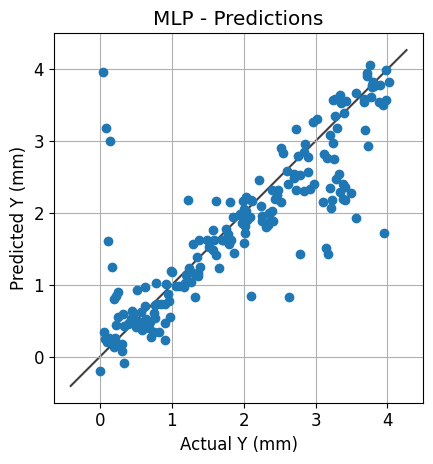

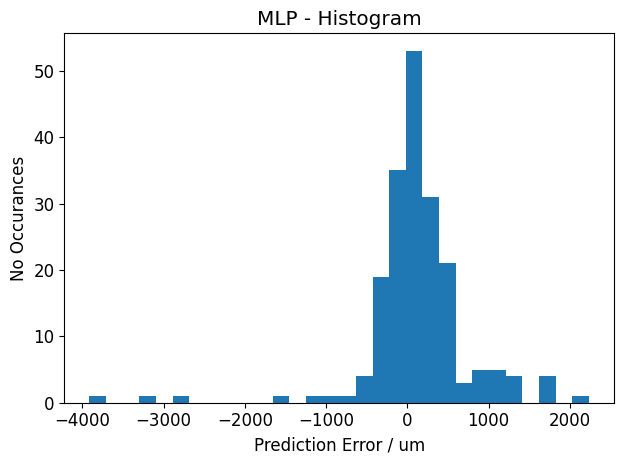

In [47]:
mlp_reg.fit(validation_split=0.33, verbose=0)
mlp_reg.score(plot_fig=False);
y = mlp_reg.val_data[1]
y_pred = mlp_reg.model.predict(mlp_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'MLP')

In [28]:
mlp_reg.cv(n_splits=10, n_repeats=10)
mlp_reg.fit(validation_split=0.33, verbose=0)
    # lstm_reg.model.model_.load_weights(lstm_reg._run_name + '.h5')
# mlp_reg.model.model_.load_weights(f'{mlp_reg._run_name}/{mlp_reg._run_name.split(mlp_reg.tb_log_dir)[1][1:]}.h5')
mlp_reg.score(plot_fig=False);

-----------------------------------------------------------------
MLP-E-1000-B-64-L[128 128 128]-D-0.01-20240808-093313


CV Model:   0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------------
CV Scores:
-----------------------------------------------------------------
MAE: 181.111 (±56.784)µm
MSE: 221587.143 (±299332.300) µm²
R^2: 0.836 (± 0.218)
-----------------------------------------------------------------
MLP-E-1000-B-64-L[128 128 128]-D-0.01-20240808-093313
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 355.611 um
MSE = 313601.413 um^2
R^2 = 0.781


(array([16., 17., 11.,  8., 12.,  8.,  6.,  4.,  4.,  0.,  4.,  0.,  1.,
         1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01453111, 0.04868269, 0.08283427, 0.11698586, 0.15113744,
        0.18528903, 0.21944061, 0.2535922 , 0.28774378, 0.32189537,
        0.35604695, 0.39019854, 0.42435012, 0.4585017 , 0.49265329,
        0.52680487, 0.56095646, 0.59510804, 0.62925963, 0.66341121,
        0.6975628 , 0.73171438, 0.76586597, 0.80001755, 0.83416913,
        0.86832072, 0.9024723 , 0.93662389, 0.97077547, 1.00492706,
        1.03907864, 1.07323023, 1.10738181, 1.1415334 , 1.17568498,
        1.20983656, 1.24398815, 1.27813973, 1.31229132, 1.3464429 ,
        1.38059449, 1.41474607, 1.44889766, 1.48304924, 1.51720082,
        1.55135241, 1.58550399, 1.61965558, 1.65380716, 1.68795875,
        1.72211033]),
 <BarContainer

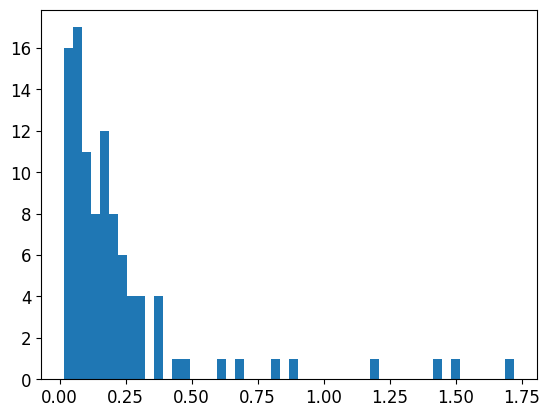

In [29]:
cv_mse_mlp = [scores['MSE'] for scores in mlp_reg.cvScores]
plt.hist(cv_mse_mlp, bins=50)

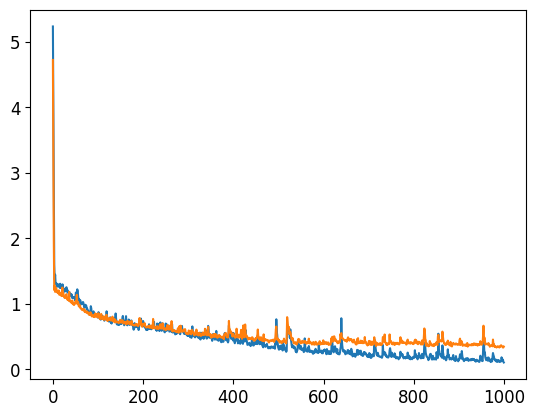

In [48]:
loss = [l for l in mlp_reg.model.history_['loss']]
val_loss = [l for l in mlp_reg.model.history_['val_loss']]

plt.plot(loss)
plt.plot(val_loss)
# plt.ylim([0, 5e-4])
# plt.yscale('log')

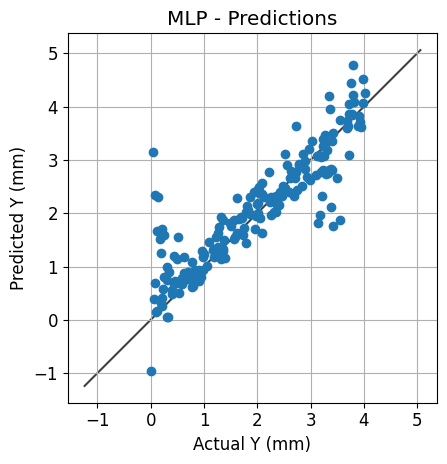

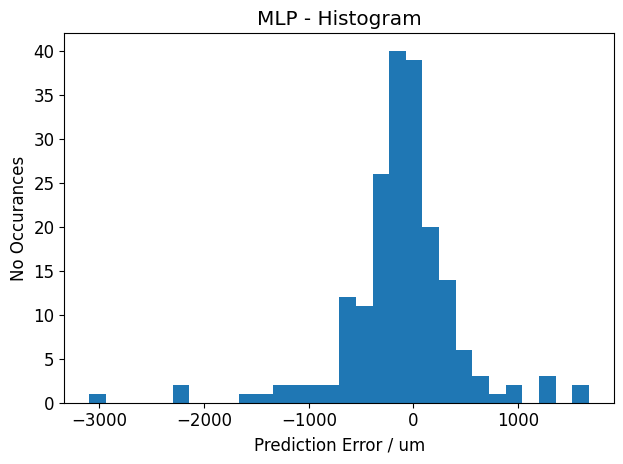

In [31]:
y = mlp_reg.val_data[1]
y_pred = mlp_reg.model.predict(mlp_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'MLP')

## MLP with Window

In [ ]:
mlp_win_reg = MLP_Win_Model(feature_df=main_df,
                            target='Mean radius',
                            tb=True,
                            tb_logdir='loss_plot',
                            params={'seq_len': 5,
                                    'loss': 'mse',
                                    'epochs': 1000,
                                    'no_nodes': 128,
                                    'no_layers': 4,
                                    'batch_size': 64,
                                    'init_mode': 'glorot_uniform',
                                    'dropout': 0.01,
                                    'callbacks': [
                                        # tf.keras.callbacks.EarlyStopping(
                                        #     monitor='val_loss',
                                        #     patience=100,
                                        #     mode='min',
                                        #     start_from_epoch=200,
                                        # ),
                                        ]
                                    },
                            random_state=11,
                            )

In [ ]:
mlp_win_reg.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{mlp_win_reg._run_name}/{mlp_win_reg._run_name.split(mlp_win_reg.tb_log_dir)[1][1:]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [ ]:
mlp_win_reg.cv(n_splits=10, n_repeats=10)
mlp_win_reg.fit(validation_split=0.2, verbose=0)
# mlp_win_reg.model.model_.load_weights(f'{mlp_win_reg._run_name}/{mlp_win_reg._run_name.split(mlp_win_reg.tb_log_dir)[1][1:]}.h5')
mlp_win_reg.score(plot_fig=False);

In [ ]:
cv_mse_mlpwin = [scores['MSE'] for scores in mlp_win_reg.cvScores]
plt.hist(cv_mse_mlpwin, bins=50)

In [ ]:
# y = mlp_win_reg.val_data[1]
# y_pred = mlp_win_reg.model.predict(mlp_win_reg.val_data[0], verbose=0)
# pred_plot(y, y_pred, 'MLP_WIN')

In [ ]:
loss = [l for l in mlp_win_reg.model.history_['loss']]
val_loss = [l for l in mlp_win_reg.model.history_['val_loss']]

plt.plot(loss)
plt.plot(val_loss)
plt.ylim([0, 5e-4])

In [ ]:
from scipy.stats import t

def dependent_ttest(data1, data2, alpha):
 # calculate means
 mean1, mean2 = np.mean(data1), np.mean(data2)
 # number of paired samples
 n = len(data1)
 # sum squared difference between observations
 d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
 # sum difference between observations
 d2 = sum([data1[i]-data2[i] for i in range(n)])
 # standard deviation of the difference between means
 sd = np.sqrt((d1 - (d2**2 / n)) / (n - 1))
 # standard error of the difference between the means
 sed = sd / np.sqrt(n)
 # calculate the t statistic
 t_stat = (mean1 - mean2) / sed
 # degrees of freedom
 df = n - 1
 # calculate the critical value
 cv = t.ppf(1.0 - alpha, df)
 # calculate the p-value
 p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
 # return everything
 return t_stat, df, cv, p

alpha = 0.05
t_stat, df, cv, p = dependent_ttest(cv_mse_mlp, cv_mse_mlpwin,alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
 print('Accept null hypothesis that the means are equal.')
else:
 print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
 print('Accept null hypothesis that the means are equal.')
else:
 print('Reject the null hypothesis that the means are equal.')

## LSTM

In [38]:
lstm_reg = LSTM_Model(feature_df=main_df,
                      target='Avg probe',
                      tb=False,
                      tb_logdir='loss_plot',
                      params={'seq_len': 15,
                              'loss': 'mse',
                              'epochs': 1000,
                              'no_layers': 2,
                              'no_dense': 1,
                              'no_nodes': 64,
                              'batch_size': 64,
                              'init_mode': 'glorot_uniform',
                              'dropout': 0.01,
                              'callbacks': [
                                        # tf.keras.callbacks.EarlyStopping(
                                        #     monitor='val_loss',
                                        #     patience=100,
                                        #     mode='min',
                                        #     start_from_epoch=500,
                                        # ),
                                        ]
                              },
                      random_state=2,
                      shuffle=True,
                      )

In [ ]:
lstm_reg.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{lstm_reg._run_name}/{lstm_reg._run_name.split(lstm_reg.tb_log_dir)[1][1:]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [ ]:
# lstm_reg.cv(n_splits=10, n_repeats=10)
lstm_reg.fit(validation_split=0.2, verbose=0)
# lstm_reg.model.model_.load_weights(f'{lstm_reg._run_name}/{lstm_reg._run_name.split(lstm_reg.tb_log_dir)[1][1:]}.h5')
lstm_reg.score(plot_fig=False);

In [39]:
lstm_reg.fit(validation_split=0.33, verbose=0)
lstm_reg.score(plot_fig=False);

-----------------------------------------------------------------
LSTM-WLEN-15-E-1000-B-64-L-[64 64 64]-D-0.01-20240808-104637
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 68.481 um
MSE = 89946.741 um^2
R^2 = 0.937


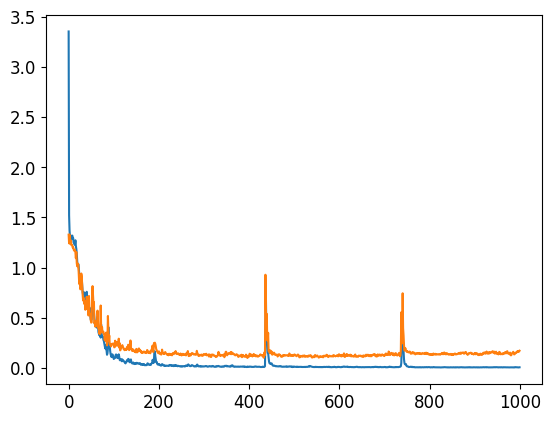

In [40]:
loss = [l for l in lstm_reg.model.history_['loss']]
val_loss = [l for l in lstm_reg.model.history_['val_loss']]

plt.plot(loss)
plt.plot(val_loss)
# plt.ylim([0, 5e-4])

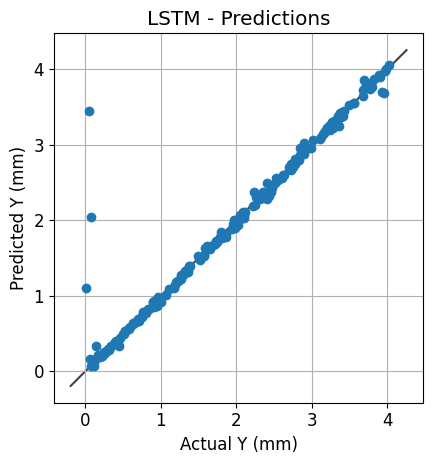

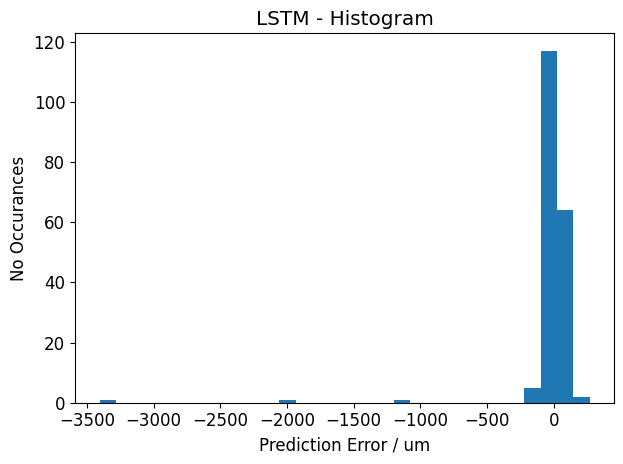

In [41]:
y = lstm_reg.val_data[1]
y_pred = lstm_reg.model.predict(lstm_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'LSTM')

## Linear Model

In [8]:
lin_reg = Linear_Model(feature_df=main_df, target='Mean radius')

In [9]:
lin_reg.fit()
lin_reg.score(plot_fig=False);

ValueError: Found input variables with inconsistent numbers of samples: [139, 553]

In [10]:
y = lin_reg.val_data[1].values
y_pred = lin_reg.model.predict(lin_reg.val_data[0].values)
pred_plot(y, y_pred, 'Linear')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Figures for Journal

In [ ]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    xmax = 0.68
    xmin = 0.6

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([xmin, xmax])

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    return ax


models = {'MLP': mlp_reg, 
          'MLP_WIN': mlp_win_reg, 
          'LSTM': lstm_reg
          }

y = {name: mod.val_data[1] for name, mod in models.items()}
y_pred = {name: mod.model.predict(mod.val_data[0], verbose=0) for name, mod in models.items()}

fig, ax = plt.subplots(1, len(models), figsize=(12, 5), sharey=True, dpi = 100)
ax = ax.ravel()
for i, m in enumerate(models):
    ax[i] = pred_real_plot(y[str(m)], y_pred[str(m)], ax[i])
    ax[i].set_title(str(m), fontsize=12)
    ax[i].set_xlabel('Actual Y (mm)', fontsize=12)
ax[0].set_ylabel('Predicted Y (mm)', fontsize=12)
fig.tight_layout()

y = {name: mod.train_data[1] for name, mod in models.items()}
y_pred = {name: mod.model.predict(mod.train_data[0], verbose=0) for name, mod in models.items()}

fig, ax = plt.subplots(1, len(models), figsize=(12, 5), sharey=True, dpi = 100)
ax = ax.ravel()
for i, m in enumerate(models):
    ax[i] = pred_real_plot(y[str(m)], y_pred[str(m)], ax[i])
    ax[i].set_title(str(m), fontsize=12)
    ax[i].set_xlabel('Actual Y (mm)', fontsize=12)
ax[0].set_ylabel('Predicted Y (mm)', fontsize=12)
fig.tight_layout()

#### Show prediction of entire wear cycle

In [ ]:
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def sequence_data(d: np.ndarray, mod):
    seq_data = []
    seq_len = mod.seq_len
    prev_points = deque(maxlen=seq_len)

    for i in d:
        prev_points.append([n for n in i])
        if len(prev_points) == seq_len:
            seq_data.append([np.array(prev_points)])
    return seq_data


dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]

fig, ax = plt.subplots(1, len(dfs), figsize=(15, 5), dpi = 300)
ax = ax.ravel()

for i, df in enumerate(dfs):

    df = df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff']).drop([0, 1, 2, 3])
    df.reset_index(drop=True, inplace=True)
    df.head()

    mods = {'MLP': mlp_reg,
            'MLP_WIN': mlp_win_reg,
            'LSTM': lstm_reg,
            }

    x = df.drop(columns=['Mean radius']).to_numpy()
    y = df['Mean radius'].to_numpy()

    x_mlp = mods['MLP'].scaler.transform(x)

    x_mlp_win = sequence_data(mods['MLP_WIN'].scaler.transform(x), mods['MLP_WIN'])
    x_mlp_win = np.asarray(x_mlp_win).reshape(len(x_mlp_win), mods['MLP_WIN']._no_features)

    x_lstm = sequence_data(mods['LSTM'].scaler.transform(x), mods['LSTM'])
    x_lstm = np.asarray(x_lstm).squeeze()

    y_pred_mlp = mods['MLP'].model.predict(x_mlp, verbose=0)
    y_pred_mlp_win = mods['MLP_WIN'].model.predict(x_mlp_win, verbose=0)
    y_pred_lstm = mods['LSTM'].model.predict(x_lstm, verbose=0)

    # print(f'Test {i + 1}')
    # print('-' * 65)
    # print('\tMLP')
    # mods['MLP'].score(X=x_mlp, y=y, plot_fig=False)
    # print('-' * 65)
    # print('\tMLP_WIN')
    # mods['MLP_WIN'].score(X=x_mlp_win, y=y[-len(x_mlp_win):], plot_fig=False)
    # print('-' * 65)
    # print('\tLSTM')
    # mods['LSTM'].score(X=x_lstm, y=y[-len(x_lstm):], plot_fig=False)
    # print('\n')

    mlp_win_slen = mods['MLP_WIN'].seq_len
    lstm_slen = mods['LSTM'].seq_len

    ax[i].plot(y, label='Actual')
    ax[i].plot(y_pred_mlp, label='MLP')
    ax[i].plot(np.insert(y_pred_mlp_win, 0, [np.NaN] * (mlp_win_slen - 1)) , label='MLP_WIN')
    ax[i].plot(np.insert(y_pred_lstm, 0, [np.NaN] * (lstm_slen - 1)), label='LSTM')
    ax[i].legend(fontsize=8)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_title(f'Test {i+1}')
    ax[i].autoscale(enable=True, axis='x', tight=True)

ax[0].set_ylabel('Mean radius (mm)')
fig.tight_layout()

# fig, ax = plt.subplots()
# pred_real_plot(y[-len(y_pred_lstm):], y_pred_lstm, ax)

#### Train MLP models on all but one Test

In [ ]:
# from collections import deque
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def sequence_data(d: np.ndarray, mod):
#     seq_data = []
#     seq_len = mod.seq_len
#     prev_points = deque(maxlen=seq_len)

#     for i in d:
#         prev_points.append([n for n in i])
#         if len(prev_points) == seq_len:
#             seq_data.append([np.array(prev_points)])
#     return seq_data

# mod = lstm_reg
# for i, val_df in enumerate(dfs):
#     tr_df = dfs[:i] + dfs[i + 1:]
#     tr_df = pd.concat(tr_df)
#     tr_df = tr_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff'])
#     tr_df.reset_index(drop=True, inplace=True)

#     mod.main_df = tr_df
#     mod.pre_process(val_frac=0.1)
#     mod.fit(verbose=0)
#     mod.score(plot_fig=False)

#     val_df = val_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff'])
#     val_x = val_df.drop(columns=['Mean radius']).to_numpy()
#     val_x = sequence_data(mod.scaler.transform(x), mod)
#     val_x = np.asarray(val_x).squeeze()
#     val_y = val_df['Mean radius'].to_numpy()
    
#     val_pred = mod.model.predict(val_x, verbose=0)
#     fig, ax = plt.subplots()
#     ax.plot(val_y, label='Actual')
#     ax.plot(np.insert(val_pred, 0, [np.NaN] * (mod.seq_len - 1)), label='Predicted')
#     ax.legend(fontsize=8)
#     ax.set_xlabel('Cut No.')
#     ax.set_ylabel('Mean radius (mm)')
#     ax.set_title(f'Val data {i+1}')
#     ax.autoscale(enable=True, axis='x', tight=True)
